# Checkpoint 6

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
#from scipy.special import erfinv
from scipy.integrate import quad
from iminuit import Minuit
from scipy.special import erf

In [130]:
def get_hist_info(data, NBINS):
    # Derive the appropriate numbers in the data
    # Here shifting x values to the center of the bins and
    # getting the height of the bin for y values
    
    n, bins = np.histogram(data, bins=NBINS)
    bins = [(bins[i] + bins[i+1])/2. for i in range(len(bins)-1)]
    bins = np.array(bins)
    n = np.array(n)
    
    return bins, n

In [131]:
NBINS = 100
MEAN = 2.5
LIFETIME = 5
SIGMA = 0.2
F = 0.98

data = np.loadtxt('datafile-higgs.txt')
x, y = get_hist_info(data, NBINS) # For plotting the data as sanity check only

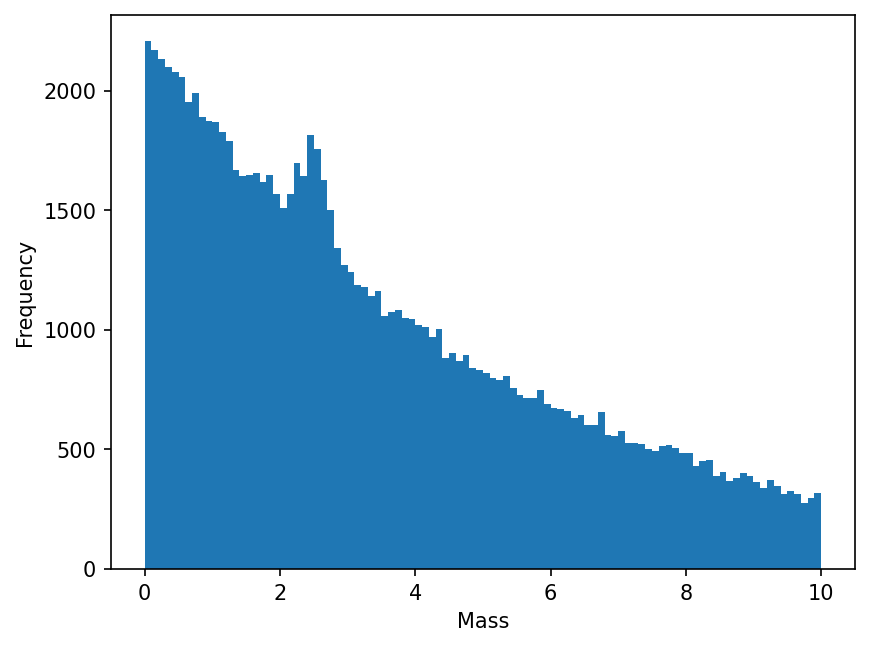

In [132]:
plt.figure(dpi=150)
plt.hist(data, bins=NBINS)
plt.xlabel("Mass")
plt.ylabel("Frequency")
plt.show()

In [133]:
# Class recycled from week 8 (Linear)
# Removed any slope arguments since model is flat which would output a horizontal line
class linear:
    def __init__(self, intercept, slope, lolimit, hilimit):
        self.intercept = intercept
        self.slope = slope
        
        self.lolimit = lolimit
        self.hilimit = hilimit

        self.mass = []
        self.maxval = self.evaluate(self.lolimit if self.slope < 0. else self.hilimit)
       
    def evaluate(self, t):
        # Normalized linear
        return (self.intercept + self.slope*t)/self.integral()
    
    def integral(self):
        return ((self.slope/2)*(self.hilimit**2)) - ((self.slope/2)*(self.lolimit**2)) + (self.intercept*(self.hilimit-self.lolimit))

    def next(self):        
        doLoop = True
        while (doLoop):
            # start with uniform random number in [lolimit , hilimit)
            x = np.random.uniform(self.lolimit, self.hilimit)
            y1 = self.evaluate(x)
            y2 = np.random.uniform(0, self.maxval)

            if (y2 < y1):
                filtered_x = x
                self.mass.append(filtered_x)
                return filtered_x



class exponential:
    def __init__(self, lifetime, lolimit, hilimit):
        self.lifetime = lifetime
        self.lolimit  = lolimit 
        self.hilimit = hilimit

    def evaluate(self, mean):
        # Normalized exponential
        return np.exp(-(mean/self.lifetime))/self.integral()
    
    def integral(self):
        return ((self.lifetime*np.exp(-(self.lolimit/self.lifetime)))-(self.lifetime*np.exp(-(self.hilimit/self.lifetime))))



# Gaussian recycled from week 8
class gaussian:
    def __init__(self, mean, sigma, lolimit, hilimit):
        self.mean = mean
        self.sigma = sigma
        self.lolimit  = lolimit
        self.hilimit = hilimit
        self.pdf = norm(self.mean, self.sigma).pdf

    def evaluate(self, x):
        # Normalized Gaussian
        return np.exp(-(0.5*np.square((x-self.mean)/self.sigma)))/self.integral()
    
    def integral(self):
        return ((np.sqrt(np.pi)*(erf((self.mean-self.lolimit)/(np.sqrt(2)*self.sigma))-erf((self.mean-self.hilimit)/(np.sqrt(2)*self.sigma))))*self.sigma)/np.sqrt(2)



class polynomial:
    def __init__(self, a, b, c, lolimit, hilimit):
        self.a = a
        self.b = b
        self.c = c
        self.lolimit = lolimit
        self.hilimit = hilimit

    def evaluate(self, x):
        # Normalized polynomial
        return (self.a + self.b*x + self.c*np.square(x))/self.integral()
    
    def integral(self):
        return ((self.c/3)*np.power(self.hilimit, 3) + (self.b/2)*np.square(self.hilimit) + self.a*self.hilimit) - \
               ((self.c/3)*np.power(self.lolimit, 3) + (self.b/2)*np.square(self.lolimit) + self.a*self.lolimit)


### Part 1

```
# Sanity check with given parameters

# Fixing values for mean, lifetime, and fractional signal strength 
# to check what model parameter should (roughtly) come out of Minuit

# Setting values declerated above from question
expo = exponential(LIFETIME, np.min(x), np.max(x))
gauss = gaussian(MEAN, SIGMA, np.min(x), np.max(x))
N_exp = np.array((F*expo.evaluate(x) + (1-F)*gauss.evaluate(x)))

norm_factor = (len(data)/np.sum(N_exp))
plt.hist(data, bins=100, label="Data", density=True)
plt.plot(np.linspace(np.min(x), np.max(x), len(N_exp)), N_exp, label="Theoretical Fit", color="orange", alpha=0.9)
plt.xlabel("Mass")
plt.ylabel("Frequency")
plt.legend()
plt.show()

##### i.

In [135]:
def min_func(mean, lifetime, F):
    """
    Function to minimize with an exponential (background) and gaussian (signal) fit

    Parameters
    ----------
    mean : float
        Mean of the gaussian
    lifetime : float
        Lifetime of the exponential
    F : float
        Fraction of background strength

    Returns
    -------
    float
        Negative log likelihood
    """
    
    expo = exponential(lifetime, 0, 10)
    gauss = gaussian(mean, SIGMA, 0, 10)

    pdf = np.array(F*expo.evaluate(data) + (1-F)*gauss.evaluate(data))
    #pdf[pdf == 0] = 1e-10
    
    return -np.sum(np.log(pdf))

startvals = {
        'lifetime': LIFETIME,
        'mean': MEAN,
        'F': F,
    }

Min = Minuit(min_func, **startvals)
Min.errordef = 0.5
Min.hesse()
Min.migrad()  # find minimum

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.146e+05                  │              Nfcn = 49               │
│ EDM = 1.89e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean     │   2.499   │   0.015   │            │            │         │         │       │
│ 1 │ lifetime │   5.008   │   0.031   │            │            │         │         │       │
│ 2 │ F        │  0.9796   │  0.0012   │            │            │         │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────────────┐
│          │      mean  lifetime         F │
├──────────┼───────────────────────────────┤
│     mean │  0.000215 -1.59e-05  5.93e-07 │
│ lifetime │ -1.59e-05  0.000939 -4.04e-06 │
│        F │  5.93e-07 -4.04e-06  1.33e-06 │
└──────────┴───────────────────────────────┘

```
# Calculating the y values for the best fit model with the minisised values
MEAN, LIFETIME, F = Min.values[0:]
expo = exponential(LIFETIME, np.min(x), np.max(x))
gauss = gaussian(MEAN, SIGMA, np.min(x), np.max(x))

N_exp = np.array((F*expo.evaluate(x) + (1-F)*gauss.evaluate(x)))

norm_factor = (len(data)/np.sum(N_exp))
plt.hist(data, bins=100, label="Data", alpha=0.8, density=True)
plt.plot(np.linspace(np.min(x), np.max(x), len(N_exp)), N_exp, label="Minimised Fit", color="red")
plt.xlabel("Mass")
plt.ylabel("Frequency")
plt.legend()
plt.show()

ii. Determine the statistical errors on each fit parameter <br>
• If using optimise you will have to write a bit of code to find the NLL+0.5 points <br>
• If using Minuit then errors come free in the fit - but remember to set errordef=0.5
<p>
iii. Present the best fit values and errors on all parameters in clear way, i.e. with descriptive text and numerical results presented as: M = Value ± E<sub>stat</sub>
<p>
iv. Make sure the number of digits quoted is sensible – quote errors to 2 significant digits

In [136]:
MEAN, LIFETIME, F = Min.values[0:]
mean_err, lifetime_err, F_err = Min.errors[0:]

print("Gaussian mean: {:.1f} \u00B1 {:.2g}".format(MEAN, mean_err))
print("Mean lifetime: {:.1f} \u00B1 {:.2g}".format(LIFETIME, lifetime_err))
print("Signal Fraction: {:.2f} \u00B1 {:.2g}".format(F, F_err))

Gaussian mean: 2.5 ± 0.015
Mean lifetime: 5.0 ± 0.031
Signal Fraction: 0.98 ± 0.0012


### Part 2

```
def min_chi2(lifetime, mean, F):
    # Defined a Minuit specific funtion for chi^2 minimisation
    # for null Hypothesis only, therefore set with flat + guassian model

    expo = exponential(lifetime)
    gauss = gaussian(mean, sigma)

    total = 0.
    for x_val, N_obs in zip(x, y):
        N_exp = F*expo.evaluate(x_val) + (1-F)*gauss.evaluate(x_val)
        if N_exp < 0.:
            N_exp = 1e-20

        #print(N_obs, N_exp, np.log(N_obs/N_exp))
        total += (N_exp - N_obs + (N_obs*np.log(N_obs/N_exp)))
    return (2*total)


for i in bins:
    startvals_H1 = {
            'intercept': 1,
            'mean': i
        }

    Min_H1 = Minuit(min_chi2_H1, **startvals_H1)
    Min_H1.fixed['mean'] = True
    Min_H1.hesse()
    Min_H1.migrad()  # find minimum

    Chi_2_H1 = min_chi2_H1(Min_H1.values['intercept']-1, Min_H1.values['mean'])
    Chi_2_diff.append(Chi_2_H0 - Chi_2_H1)

Chi_2_diff = np.array(Chi_2_diff)

##### i, ii.

```
# Sanity check block 

# Fixing values for mean, lifetime, and fractional signal strength 
# with given parameters to check what model parameter should come 
# out of Minuit and veryfing normalisation factor are correct

poly = polynomial(1, -0.16, 0.007, 0, 10)
gauss = gaussian(2.5, 0.2, 0, 10)
F = 0.98
N_exp = np.array((F*poly.evaluate(x) + (1-F)*gauss.evaluate(x)))

norm_factor = (len(data)/np.sum(N_exp))
plt.hist(data, bins=100, label="Data", density=True)
plt.plot(np.linspace(np.min(x), np.max(x), len(N_exp)), N_exp, label="Theoretical Fit", color="orange", alpha=0.9)
plt.xlabel("Mass")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [137]:
def min_func_poly(mean, b_a, c_a, F):
    """
    Function to minimize for polynomial fit

    Parameters
    ----------
    mean : float
        Mean of the gaussian
    b_a : float
        Coefficient of the linear term in terms of A (b/a)
    c_a : float
        Coefficient of the quadratic term in terms of A (c/a)
    F : float
        Fraction of background strength
    
    Returns
    -------
    float
        Negative log likelihood
    """
    
    b = b_a * A
    c = c_a * A

    poly = polynomial(A, b, c, 0, 10)
    gauss = gaussian(mean, SIGMA, 0, 10)

    pdf = np.array(F*poly.evaluate(data) + (1-F)*gauss.evaluate(data))
    #pdf[pdf == 0] = 1e-10
    
    return -np.sum(np.log(pdf))

A = 1
startvals = {
        'b_a': -0.16,
        'c_a': 0.007,
        'mean': 2.5,
        'F': 0.98,
    }

Min_Poly = Minuit(min_func_poly, **startvals)
Min_Poly.errordef = 0.5
Min_Poly.hesse()
Min_Poly.migrad()  # find minimum

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.146e+05                  │              Nfcn = 101              │
│ EDM = 6.87e-07 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean │   2.494   │   0.015   │            │            │         │         │       │
│ 1 │ b_a  │  -0.1578  │  0.0012   │            │            │         │         │       │
│ 2 │ c_a  │  7.30e-3  │  0.14e-3  │            │            │         │         │       │
│ 3 │ F    │  0.9820   │  0.0012   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬─────────────────────────────────────────┐
│      │      mean       b_a       c_a         F │
├──────┼─────────────────────────────────────────┤
│ mean │  0.000231 -1.06e-06  1.14e-07  2.31e-07 │
│  b_a │ -1.06e-06  1.44e-06  -1.6e-07  2.01e-08 │
│  c_a │  1.14e-07  -1.6e-07  1.83e-08 -6.19e-09 │
│    F │  2.31e-07  2.01e-08 -6.19e-09  1.33e-06 │
└──────┴─────────────────────────────────────────┘

In [138]:
print("Polynomial Fit Parameters:")
print("--------------------------")

MEAN_POLY, B_A, C_A, F = Min_Poly.values[0:]
mean_err_poly, b_a_err, c_a_err, F_err_poly = Min_Poly.errors[0:]

print("The Gaussian Mean: {:.3g} \u00B1 {:.2g}".format(MEAN_POLY, mean_err))
print("b/a Parmeter: {:.3g} \u00B1 {:.2g}".format(B_A, b_a_err))
print("c/a Parmeter: {:.3g} \u00B1 {:.2g}".format(C_A, c_a_err))
print("Fraction F: {:.2g} \u00B1 {:.2g}".format(F, F_err))

Polynomial Fit Parameters:
--------------------------
The Gaussian Mean: 2.49 ± 0.015
b/a Parmeter: -0.158 ± 0.0012
c/a Parmeter: 0.0073 ± 0.00014
Fraction F: 0.98 ± 0.0012


##### iii.

In [152]:
E_syst = np.abs(MEAN - MEAN_POLY)
print("Mean of the Gaussian: {:.3g} \u00B1 {:.2g} \u00B1 {:.2g}".format(MEAN, mean_err, E_syst))

Mean of the Gaussian: 2.5 ± 0.015 ± 0.0042


##### iv.

In [153]:
E_tot = np.sqrt(np.square(mean_err) + np.square(E_syst))
print("Mean of the Gaussian: {:.3g} \u00B1 {:.2g}".format(MEAN, E_tot))

Mean of the Gaussian: 2.5 ± 0.015


##### v.

Considering the systematic error (to 2 significant figures) estimated with the polynomial and exponential models for the background, it doesn't make a large change the in total error. This error is negligible and it can be ignored. The systematic is only considered if it is approximately equal to the statical error.

```
# Sanity check block 

# Calculating the y values for the best fit model with the minisised values
gauss = gaussian(MEAN, SIGMA, np.min(x), np.max(x))

MEAN_exp, LIFETIME, F_EXP = Min.values[0:]
expo = exponential(LIFETIME, np.min(x), np.max(x))
N_exp_exp = np.array((F_EXP*expo.evaluate(x) + (1-F_EXP)*gauss.evaluate(x)))

MEAN_poly, B_A, C_A, F_POLY = Min_Poly.values[0:]
poly = polynomial(A, B_A, C_A, 0, 10)
N_exp_poly = np.array((F_POLY*poly.evaluate(x) + (1-F_POLY)*gauss.evaluate(x)))

norm_factor = (len(data)/np.sum(N_exp))
plt.hist(data, bins=100, label="Data", alpha=0.8, density=True)
plt.plot(np.linspace(np.min(x), np.max(x), len(N_exp_poly)), N_exp_poly, label="Minimised Fit Polynomial", color="red")
plt.plot(np.linspace(np.min(x), np.max(x), len(N_exp_exp)), N_exp_exp, label="Minimised Fit Exponential", color="green")
plt.xlabel("Mass")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Part 3

##### i.

In [141]:
def min_func_lin(mean, b_a, F):
    """
    Function to minimize for linear fit

    Parameters
    ----------
    mean: float
        Mean of the gaussian
    slope: float
        Slope of the linear term
    intercept: float
        Intercept of the linear term
    F: float
        Fraction of background strength
    
    Returns
    -------
    float
        Negative log likelihood    
    """
    B = b_a * A
    lin = linear(A, B, 0, 10)
    gauss = gaussian(mean, SIGMA, 0, 10)

    pdf = np.array(F*lin.evaluate(data) + (1-F)*gauss.evaluate(data))

    return -np.sum(np.log(pdf))

A = 1
startvals = {
        'b_a': -0.09,
        'mean': 2.5,
        'F': 0.98,
    }

Min_lin = Minuit(min_func_lin, **startvals)
Min_lin.errordef = 0.5
Min_lin.hesse()
Min_lin.migrad()  # find minimum

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.155e+05                  │              Nfcn = 56               │
│ EDM = 6.71e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean │   2.466   │   0.015   │            │            │         │         │       │
│ 1 │ b_a  │ -90.40e-3 │  0.23e-3  │            │            │         │         │       │
│ 2 │ F    │  0.9801   │  0.0012   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬───────────────────────────────┐
│      │      mean       b_a         F │
├──────┼───────────────────────────────┤
│ mean │  0.000232 -1.87e-07  7.97e-07 │
│  b_a │ -1.87e-07  5.23e-08 -4.07e-08 │
│    F │  7.97e-07 -4.07e-08  1.37e-06 │
└──────┴───────────────────────────────┘

```
# Sanity check block 

# Fixing values for mean, lifetime, and fractional signal strength 
# with given parameters to check what model parameter should come 
# out of Minuit and veryfing normalisation factor are correct

mean, b_a, F = Min_lin.values[0:]

B = b_a * A
lin = linear(A, B, 0, 10)
gauss = gaussian(mean, 0.2, 0, 10)

N_exp = np.array((F*lin.evaluate(x) + (1-F)*gauss.evaluate(x)))

norm_factor = (len(data)/np.sum(N_exp))
plt.hist(data, bins=100, label="Data")
plt.plot(np.linspace(np.min(x), np.max(x), len(N_exp)), N_exp*norm_factor, label="Linear Fit", color="red")
plt.xlabel("Mass")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [142]:
print("Linear Fit Parameters:")
print("--------------------------")

MEAN_LIN, B_A, F = Min_lin.values[0:]
mean_err_lin, b_a_err_lin, F_err_lin = Min_lin.errors[0:]

print("The Gaussian Mean: {:.3g} \u00B1 {:.2g}".format(MEAN_LIN, mean_err_lin))
print("b/a Parmeter: {:.3g} \u00B1 {:.2g}".format(B_A, b_a_err_lin))
print("Fraction F: {:.2g} \u00B1 {:.2g}".format(F, F_err_lin))

Linear Fit Parameters:
--------------------------
The Gaussian Mean: 2.47 ± 0.015
b/a Parmeter: -0.0904 ± 0.00023
Fraction F: 0.98 ± 0.0012


##### ii.

In [143]:
E_syst = np.abs(MEAN - MEAN_LIN)
print("Mean of the Gaussian: {:.2g} \u00B1 {:.2g} \u00B1 {:.2g}".format(MEAN, mean_err_lin, E_syst))

Mean of the Gaussian: 2.5 ± 0.015 ± 0.033


##### iii.

In [144]:
E_tot = np.sqrt(np.square(mean_err) + np.square(E_syst))
print("Mean of the Gaussian: {:.2g} \u00B1 {:.2g}".format(MEAN, E_tot))

Mean of the Gaussian: 2.5 ± 0.036


##### iv.

Using the linear model for this case, the statical error is slightly lower than the systematic error and therefore has to be considered into the total error on the mean. The value for the total error has been changed significantly, unlike the previous case. 